#### Name and source statement
Enter your name (in the requested format, please) and your github handle. Also add a statement on your sources. You are allowed to look up things and use AI tools, but you need to honestly state what you used and how, e.g. to resolve errors, understand something better, or generate (partial) solutions. This is required, don't forget.

In [15]:
# Fill in your name using the given format, GitHub handle, and sources
your_name = "MAINARDI, LUCA"
github_handle = "luca-mainardi"
statement = """
            I used the notebooks provided for the laboratories of this course and the scikit-learn documentation as sources. 
            I also used github copilot and chatGPT to resolve errors in my code and to get explanations of the code already in the assignment notebook. 
            Copilot was also used for code generation of some functions.
            """

In [16]:
import validation

# Assignment 1

In this assignment we'll use machine learning to recognize text in Devanagari, one of the oldest scripts of India. It is the world’s fourth most used script after Latin, Chinese and Arabic, used in nearly 120 languages and dialects, including Nepali, Marathi and Hindi. The word Devanagari means ‘that from the city of gods’.

<img src='https://storytrails.in/wp-content/uploads/2023/01/Devanagari-1536x1035.jpg' width=600>

This [dataset](https://www.openml.org/d/40923) consists of 92 thousand images (32x32 pixels) of 46 characters from Devanagari script. Includes the alphabet as well as the numbers. You can read more about the construction of this dataset in [this paper](https://ashokpant.github.io/publications/ashok_2015_deep.pdf). While they used neural networks to recognize them (and we encourage you to try this as well), for this assignment we'll use simpler models.

Sidenote: this separation into characters oversimplifies the script. For instance, Devanagari has vowel modifiers such as ा (for Aa). Hence, a word like 'राम' (Rām) consists of characters र (Ra), ा (the vowel modifier), and म (Ma). The vowel modifiers are not included in the 46 characters. This may come up later in the assignment.



In [17]:
# For use in colab
if 'google.colab' in str(get_ipython()):
  !python -m pip install scikit-learn~=1.4 openml --quiet

In [18]:
# Optional: uncomment the following line to run in Google Colab
# This will link the notebook to your own Google drive to store your models and cache the dataset.
# It will ask you to click on a link to get a verification code.
# from google.colab import drive
# import gdown
# drive.mount('/content/drive', force_remount=True)

In [19]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

# import validation

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.4.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")
    
# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

OK. You may continue :)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading Devanagari data from OpenML. This may take a bit longer the first time you download it.
# Don't overwrite the X, X_eval and y, y_eval variables anywhere in this notebook.
# Seriously, don't.

data = openml.datasets.get_dataset("Devnagari-Script", download_data=True, download_features_meta_data=True, download_qualities=False)
Devanagari_X, Devanagari_y, _, _ = data.get_data(target=data.default_target_attribute)

# Scaling to [0..1]. Logistic Regression can be sensitive to scale
# We also tried standard scaling, but the results were very similar.
Devanagari_X_scaled = Devanagari_X / 255.0

# Split the data with a 50-50 split (in the interest of time/resources)
X, X_eval, y, y_eval = train_test_split(Devanagari_X_scaled, Devanagari_y, stratify=Devanagari_y, train_size=0.5, random_state=0)

# A sorted list of all labels. Uses the order used in the original dataset
labels = sorted([label for label in set(Devanagari_y)])

# A mapping with a shorter version of the labels, e.g. character_06_cha -> cha
short_labels = {label: label.split('_')[-1] for label in labels}

# Mapping of classes to Devanagari in unicode
Devanagari_mapping = {
    'ka': 'क',
    'kha': 'ख',
    'ga': 'ग',
    'gha': 'घ',
    'kna': 'ङ',
    'cha': 'च',
    'chha': 'छ',
    'ja': 'ज',
    'jha': 'झ', # The images contain an older version of 'jha' (no unicode)
    'chhya': 'क्ष',
    'yna': 'ञ',
    'daa': 'ड',
    'dhaa': 'ढ',
    'adna': 'ण',
    'tha': 'थ',
    'da': 'द',
    'dha': 'ध',
    'na': 'न',
    'pa': 'प',
    'pha': 'फ',
    'ba': 'ब',
    'bha': 'भ',
    'ma': 'म',
    'yaw': 'य',
    'ra': 'र',
    'la': 'ल',
    'waw': 'व',
    'ha': 'ह',
    'tra': 'त्र',
    'gya': 'ज्ञ',
    'taamatar': 'ट', # ṭa
    'thaa': 'ठ', # ṭha
    'tabala': 'त', # ta
    'motosaw': 'श', # śa
    'petchiryakha': 'ष', # ṣa
    'patalosaw': 'स', # sa
    '0': '०',
    '1': '१',
    '2': '२',
    '3': '३',
    '4': '४',
    '5': '५',
    '6': '६',
    '7': '७',
    '8': '८',
    '9': '९'
}

In [21]:
# Plotting helper functions. Don't edit these.
%matplotlib inline
from IPython import display
from tqdm.notebook import tqdm_notebook
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

@ignore_warnings(category=ConvergenceWarning)
def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)

    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
    plt.grid(True)

    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in tqdm_notebook(param_range):
        scores = evaluator(X, y, i)
        xvals.append(i)
        if not series:  # This checks if series dictionary is empty, meaning it's the first iteration
            for k in scores.keys():
                series[k] = [scores[k]]  # Initialize series with the first score
                lines[k], = plt.plot(xvals, series[k], marker=marker, label=k)  # Plot the initial point
        else:
            for k in scores.keys():
                series[k].append(scores[k])
                lines[k].set_data(xvals, series[k])

        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

# Plots data instances as 32x32 images
def plot_examples(images, labels, row_length=7, title=""):
    nr_rows = math.ceil(len(images) / row_length)
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(row_length, 1.1 * nr_rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for i, (index, row) in enumerate(images.iterrows()):
        axes[i].imshow(row.values.reshape(32, 32), cmap=plt.cm.Blues)
        if labels is not None:
            axes[i].set_xlabel(short_labels[labels.loc[index]])
        axes[i].set_xticks(())
        axes[i].set_yticks(())

    # Turn off any extra subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title)
    plt.show()

### Peeking at the data
If we plot the characters, we see that there is quite some variation. The same
letter can be written in slightly different ways.

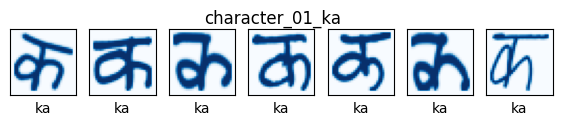

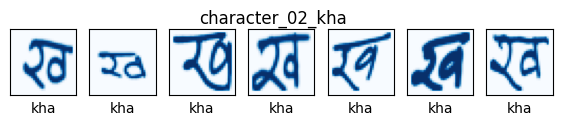

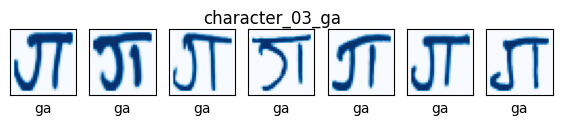

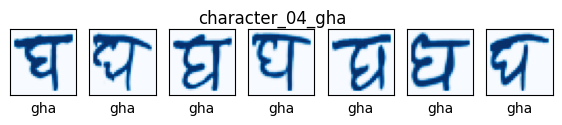

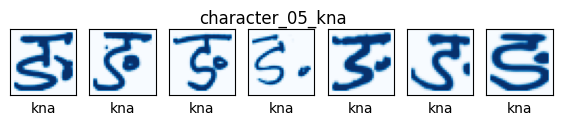

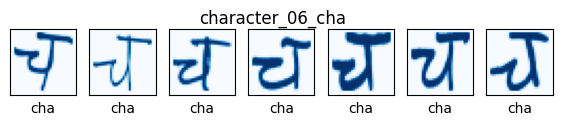

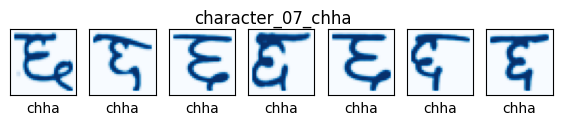

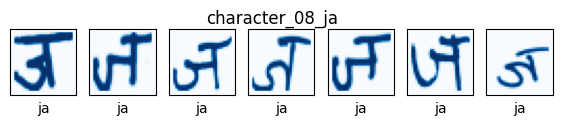

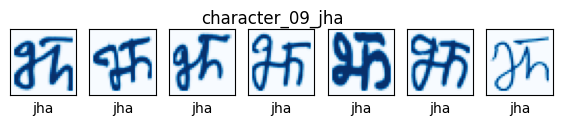

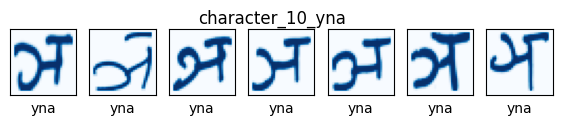

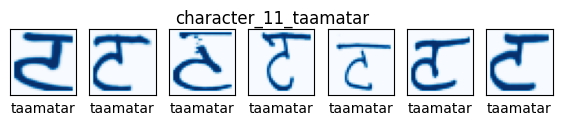

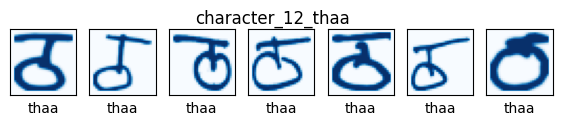

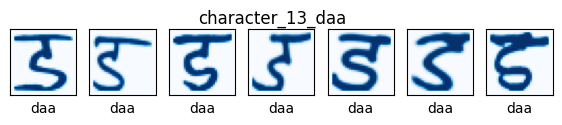

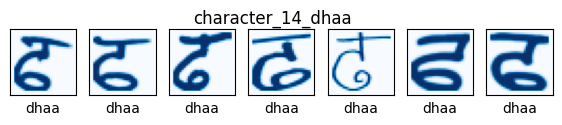

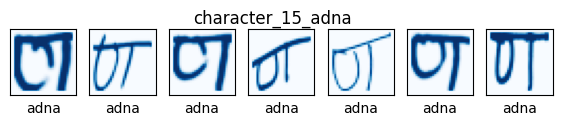

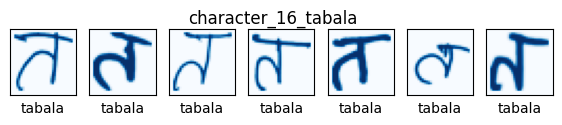

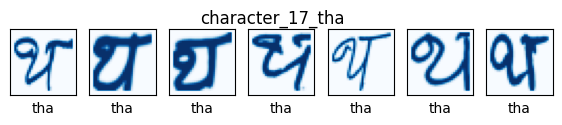

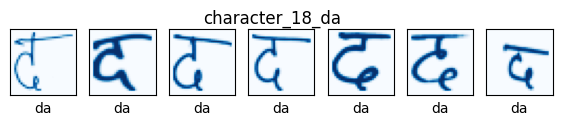

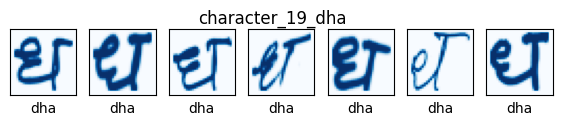

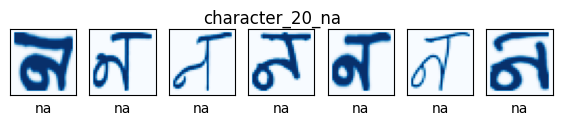

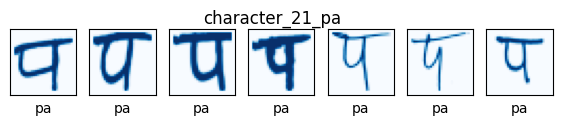

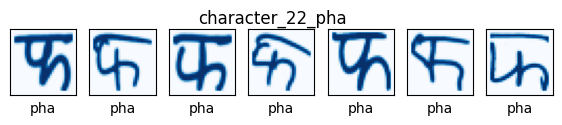

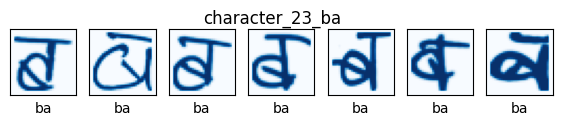

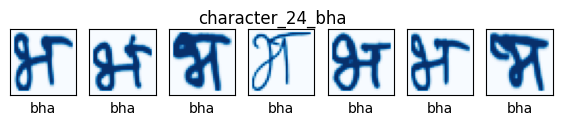

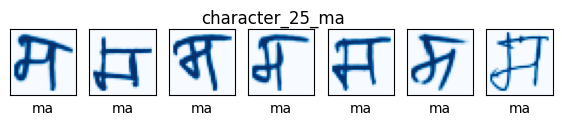

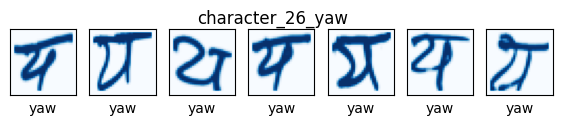

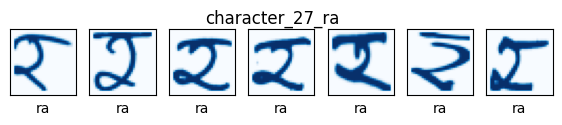

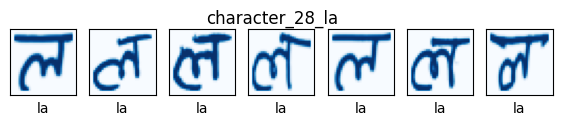

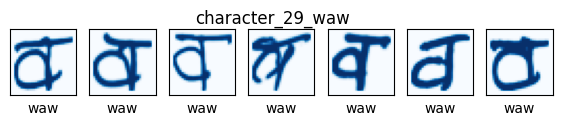

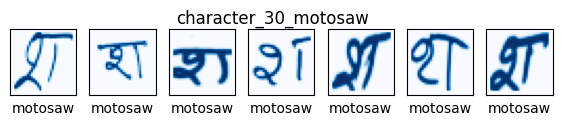

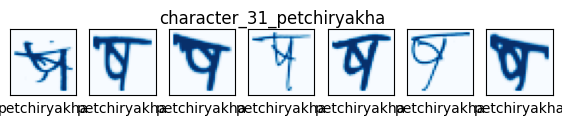

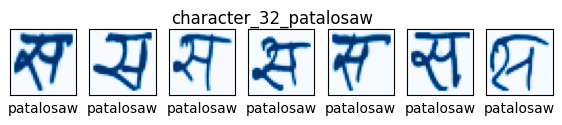

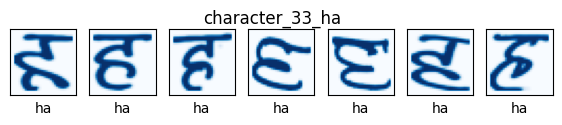

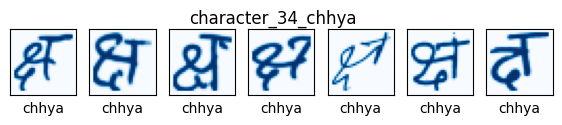

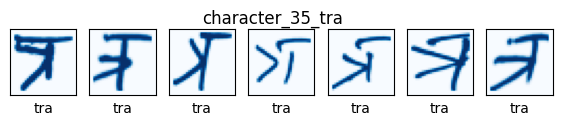

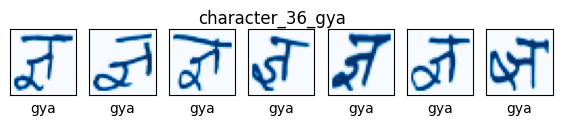

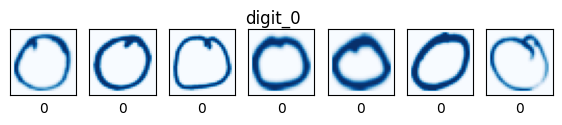

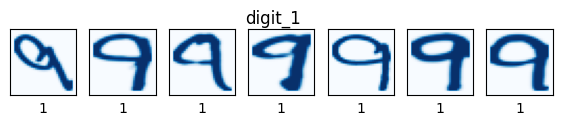

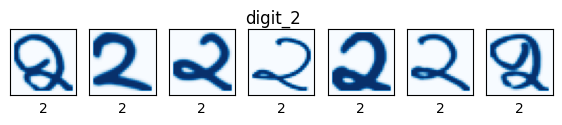

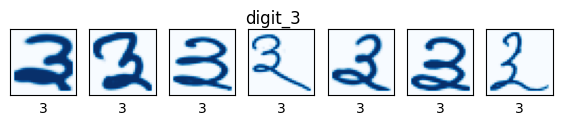

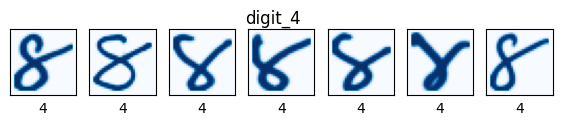

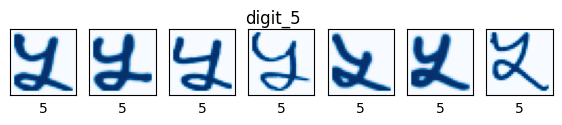

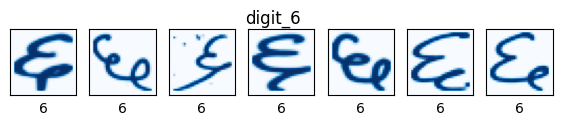

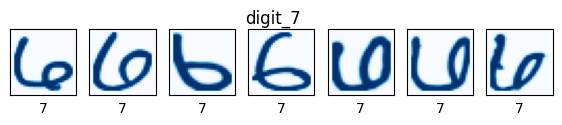

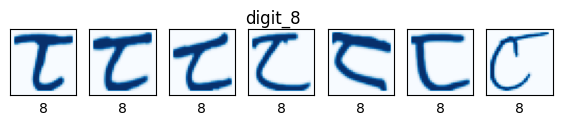

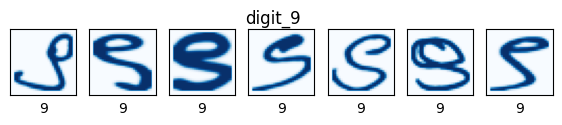

In [22]:
# Gets indices of examples with the given class
num_ex = 7
def y_class(c, num_ex):
    return y[y == c].index.values.tolist()[:num_ex]

for label in labels:
    indices = y_class(label, num_ex)
    plot_examples(X.loc[indices], y.loc[indices], row_length=num_ex, title=label)

### Question 1.1: Model tuning (1 point)
Implement a method `evaluate_LR` that evaluates a Logistic Regression model trained with a given regularization constant (C), and the Limited-memory Broyden–Fletcher–Goldfarb–Shanno (lbfgs) optimizer. It should return the train and test score of a 5-fold stratified cross-validation using the accuracy metric. You don't need to do any additional preprocessing of the data at this point. It is already scaled.

**Important:** Only use the variables passed as parameters (in this case, `X`, `y`, and `C`). Do not add additional parameters to the function, and do not use global variables in the function implementation (except for imported modules and functions, which you are free to use). These guidelines also apply to any future questions in this and future assignments.

Next, you need to find the optimal amount of regularization for this dataset. To do this, implement a method `plot_curve` that plots the training and test scores of `evaluate_LR` on a stratified subsample of size `train_size` on the Devanagari dataset, for C values ranging from at least 1e-4 (10<sup>-4</sup>) to 1e4 (10<sup>4</sup>) on a log base 10 scale, with at least 9 values. Use `random_state=0` for reproducibility. You should use the plotting function `plot_live` defined above (carefully read what it does - it will save you time!). 

We recommend tuning C on a 25% subsample of the data to `evaluate_LR`. Using a 25% subsample won't give you optimal performance, but when tuning hyperparameters (which is expensive) you can often get a pretty good estimate of the best hyperparameters by using a smaller sample. When you have a rough idea of where the good hyperparameters lie, you can evaluate these on a larger sample. This is also called multi-fidelty optimization. For this assignment, you can use a 25% subsample, although of course you are free to double-check on the entire dataset.

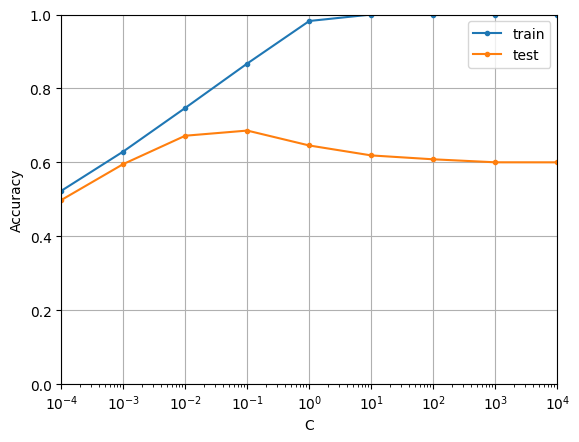

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
# Implement. Do not change the name or signature of these functions.
def evaluate_LR(X, y, C):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    C -- the regularization constant

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    model = LogisticRegression(C=C, solver='lbfgs', random_state=0, max_iter=1000)

    scores = cross_validate(model, X, y, cv=5, scoring='accuracy', return_train_score= True, n_jobs=4)
    test_score = scores['test_score']
    train_score = scores['train_score']
    return {"train": train_score.mean(), "test": test_score.mean()}
    

def plot_curve(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of regularization.
    X          -- the data for training and testing
    y          -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 
    
    Returns: a plot as described above, with C on the x-axis and accuracy on
    the y-axis.
    """
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=0)

    # Define the range of C values
    C_values = np.logspace(-4, 4, num=9)

    # Plot the curve
    plot_live(X_train, y_train, evaluate_LR, "C", C_values, scale='log', ylim=(0, 1), ylabel='Accuracy')
    

plot_curve(X,y,0.25)

In [24]:
validation.signature_unchanged(evaluate_LR)

In [25]:
validation.signature_unchanged(plot_curve)

*note:* Throughout the notebook, you will find cells that call functions on the `validation` module. You should run these cells to perform a _very_ basic test on your provided answer. If validation fails, that means there is a technical error with the provided answer (e.g., the function signature was changed). Passing validation does *not* necessarily mean your answer is correct. It is *not* a replacement for performing your own sanity checks. The `validation.py` file needs to be in the same folder as this notebook. If you are running this is Colab, you need to upload it to your working directory.

### Question 1.2: Interpretation (2 points)
Interpret the graph. Indicate which of the following answers are correct.

- 'A': Setting C=1e-4 yields a good (close to optimal) logistic regression model given this data.
- 'B': Setting C=1e-1 yields a good (close to optimal) logistic regression model given this data.
- 'C': Setting C=1e4 yields a good (close to optimal) logistic regression model given this data.
- 'D': The model trained with C=1e-4 is underfitting. We need to regularize it less.
- 'E': The model trained with C=1e-1 is underfitting. We need to regularize it less.
- 'F': The model trained with C=1e4 is underfitting. We need to regularize it less.
- 'G': The model trained with C=1e-4 is overfitting and we need to regularize it more.
- 'H': The model trained with C=1e-1 is overfitting and we need to regularize it more.
- 'I': The model trained with C=1e4 is overfitting and we need to regularize it more.
- 'J': The model trained with C=1e-4 is overfitting but only because the data is inherently complex. We need features that better capture the information in the images.
- 'K': The model trained with C=1e-1 is overfitting but only because the data is inherently complex. We need features that better capture the information in the images.
- 'L': The model trained with C=1e4 is overfitting but only because the data is inherently complex. We need features that better capture the information in the images.
- 'M': The model trained with C=1e-4 is neither underfitting nor overfitting.
- 'N': The model trained with C=1e-1 is neither underfitting nor overfitting.
- 'O': The model trained with C=1e4 is neither underfitting nor overfitting.
- 'P': The plot shows that the model gets better as we train it on more data, but at some point it starts overfitting.
- 'Q': The plot shows that the model will always overfit less when given more data.
- 'R': The Devanagari script is easy to recognize with a linear model trained on the pixel values, we can recognize characters with almost 100% accuracy.
- 'S': The Devanagari script is hard to recognize with a linear model trained on the pixel values, our accuracy is less than 75%.
- 'T': No answer

Enter the correct letter(s) in value `q_1_3` in the code. They may be separated by commas (e.g.,: `'A,B,C'`) if multiple answers are correct.

**Note**: Incorrect answers will cause a point deduction. However, you can't score negative points on this question as a whole (0/2 is the minimum).

In [26]:
# Fill in the correct answer. Don't change the name of the variable
q_1_2 = 'B, D, I, N, S'

### Question 1.3: Learning curve analysis (4 points)

Implement a method `learning_curve` that trains a Logistic Regression model trained using Stochastic Gradient Descent (SGD) on mini-batches of data and returns the training and validation accuracies after every batch. The curve that plots the model's scores after every new batch of training data is called a learning curve. Your implementation must also allow cycling multiple times over the training datasets (one pass over the training data is called an _epoch_). 

The method must first make a (single) stratified 80-20 split of the input data (with `random_state=0`), where 80% forms the training data and the other 20% the validation data. It will then cycle `n_epoch` times over the training data. Every cycle, it shuffles the data, ensuring every epoch has a different shuffle of the data, and then creates batches of training data, where each batch consists of `batch_size` training examples. It must then _incrementally_ train the Logistic Regression model on every batch, i.e. continue training the model instead of re-initializing it, and after every batch it must compute the accuracy on the entire training and validation set. After `n_epoch` passes have been computed, it returns `train_accuracies` and `val_accuracies`, both vectors with the training and validation scores after each batch, respectively.

You'll have to use the [SGD Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) to be able to do this in sklearn. Carefully consider how to use it so that it is equivalent to a Logistic Regression model, and that the regularization parameter is called `alpha`. This is an incremental learner: you can simply use `partial_fit` instead of the default `fit` to train the model incrementally. [See here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.partial_fit), and note that it requires the list of classes when first called. `SGDClassifier` also takes a hyperparameter `alpha` representing the regularization strength. For SGD you can use an `adaptive` learning rate with an initial learning rate of 0.01. With every batch, do a single optimization iteration. Use `random_state=0`.

To test the method and plot the result, we provide the simple `plot_learning_curves` method below. You must run the method on the entire (training) dataset, i.e. `X` and `y`.

Note: You'll have to implement most of this yourself. There is no handy method in sklearn that does this for you the way described here.



In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
# Implement. Do not change the name or signature of this function.
def learning_curve(X, y, alpha=0.001, n_epochs=1, batch_size=100):
    """ 
    Implement a method `learning_curve` that trains a Logistic Regression model trained using Stochastic Gradient Descent (SGD) on mini-batches of data and returns the training and validation accuracies after every batch. The curve that plots the model's scores after every new batch of training data is called a learning curve. Your implementation must also allow cycling multiple times over the training datasets (one pass over the training data is called an _epoch_). 

    The method must first make a (single) stratified 80-20 split of the input data (with `random_state=0`), where 80% forms the training data and the other 20% the validation data. It will then cycle `n_epoch` times over the training data. Every cycle, it shuffles the data, ensuring every epoch has a different shuffle of the data, and then creates batches of training data, where each batch consists of `batch_size` training examples. It must then _incrementally_ train the Logistic Regression model on every batch, i.e. continue training the model instead of re-initializing it, and after every batch it must compute the accuracy on the entire training and validation set. After `n_epoch` passes have been computed, it returns `train_accuracies` and `val_accuracies`, both vectors with the training and validation scores after each batch, respectively.

    You'll have to use the [SGD Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) to be able to do this in sklearn. Carefully consider how to use it so that it is equivalent to a Logistic Regression model, and that the regularization parameter is called `alpha`. This is an incremental learner: you can simply use `partial_fit` instead of the default `fit` to train the model incrementally. [See here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.partial_fit), and note that it requires the list of classes when first called. `SGDClassifier` also takes a hyperparameter `alpha` representing the regularization strength. For SGD you can use an `adaptive` learning rate with an initial learning rate of 0.01. With every batch, do a single optimization iteration. Use `random_state=0`.
        
    Trains a Logistic Regression model incrementally using stochastic gradient descent and returns the learning curves.
    X -- the data for training and testing
    y -- the correct labels
    alpha -- the regularization hyperparameter
    n_epochs -- the number of epochs
    batch_size -- the batch size
    Returns: Two arrays, with the training accuracies and validation accuracies, respectively, in that order.
    """
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    # Initialize the SGDClassifier
    sgd = SGDClassifier(loss='log_loss', alpha=alpha, learning_rate='adaptive', eta0=0.01, random_state=0)

    # Initialize lists to store accuracies
    train_accuracies = []
    val_accuracies = []

    # Get the unique classes
    classes = np.unique(y)

    # Repeat for each epoch
    for epoch in range(n_epochs):
        # Shuffle the training data
        X_train, y_train = shuffle(X_train, y_train, random_state=epoch)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        # Split the training data into batches
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Train the model on the batch
            sgd.partial_fit(X_batch, y_batch, classes=classes)

            # Compute the accuracies and add them to the lists
            train_accuracies.append(accuracy_score(y_train, sgd.predict(X_train)))
            val_accuracies.append(accuracy_score(y_val, sgd.predict(X_val)))

    return train_accuracies, val_accuracies

def plot_learning_curves(train_accuracies, val_accuracies, title='Learning Curve Across Epochs'):
    """ Plots the given learning curves. """
    if len(train_accuracies) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Number of Batches')
        plt.ylabel('Accuracy')
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.show()

train_accuracies, val_accuracies = learning_curve(X,y)

# Uncomment for testing
# plot_learning_curves(train_accuracies, val_accuracies)

/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.

### Question 1.4: Interpretation (2 points)
Plot the learning curves of these three models and interpret them.

- The model using the default setting, `alpha=0.001`
- Same model, but with `alpha=0.01`
- Same model, but trained for 8 epochs on 1/8th of the data

/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.

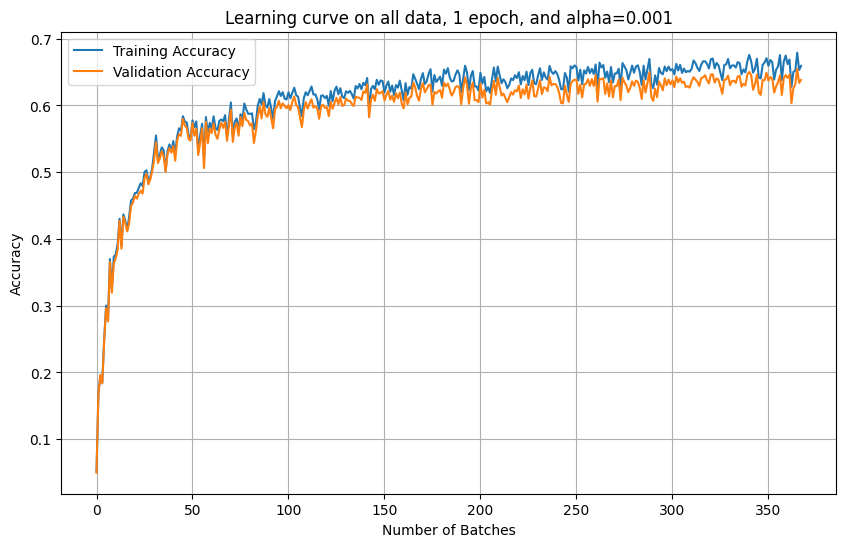

/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.

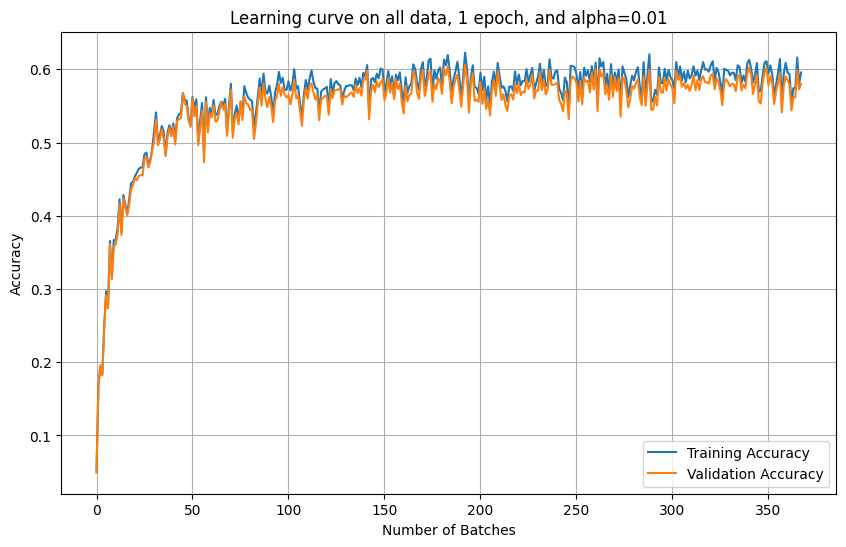

/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/Users/lucamainardi/Documents/TUe/MLE/assignment-1-2024-luca-mainardi/.venv/lib/python3.

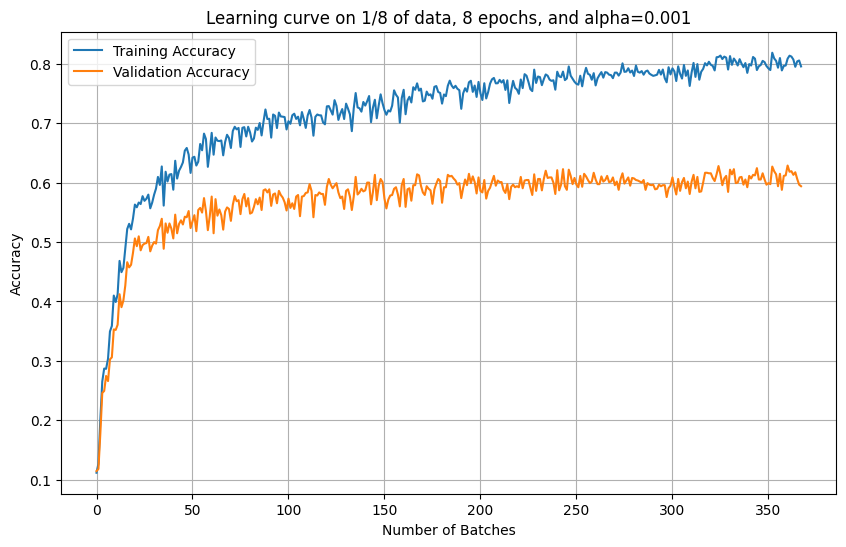

In [28]:
plot_learning_curves(*learning_curve(X, y, alpha=0.001), title="Learning curve on all data, 1 epoch, and alpha=0.001")

plot_learning_curves(*learning_curve(X, y, alpha=0.01), title="Learning curve on all data, 1 epoch, and alpha=0.01")

X_train, _, y_train, _ = train_test_split(X, y, stratify=y, train_size=0.125, random_state=0)
plot_learning_curves(*learning_curve(X_train, y_train, alpha=0.001, n_epochs=8), title="Learning curve on 1/8 of data, 8 epochs, and alpha=0.001")

Interpret the graphs. Indicate which of the following answers are correct.  
*Note*: Feel free to run additional experiments if you feel that you need them.

- 'A': The first model (all data, alpha=0.001) is well-tuned. It doesn't show clear under- or overfitting.
- 'B': The first model (all data, alpha=0.001) is clearly underfitting more than the others.
- 'C': The first model (all data, alpha=0.001) is clearly overfitting more than the others.
- 'D': The second model (all data, alpha=0.01) is well-tuned. It doesn't show clear under- or overfitting.
- 'E': The second model (all data, alpha=0.01) is clearly underfitting more than the others.
- 'F': The second model (all data, alpha=0.01) is clearly overfitting more than the others.
- 'G': The third model (1/8 data, 8 epochs, alpha=0.001) is well-tuned. It doesn't show clear under- or overfitting.
- 'H': The third model (1/8 data, 8 epochs, alpha=0.001) is clearly underfitting more than the others.
- 'I': The third model (1/8 data, 8 epochs, alpha=0.001) is clearly overfitting more than the others.
- 'J': Everything else being equal, higher values of alpha lead to more overfitting
- 'K': Everything else being equal, higher values of alpha lead to more underfitting
- 'L': Training on smaller datasets leads to more overfitting, even when training for more epochs.
- 'M': As we train on more epochs, the model will first improve, but later it will always start overfitting.
- 'N': Since this is Logistic Regression, it will never overfit.
- 'O': The training and validation scores behave very similarly. If one increases on a batch, the other will do so, too, and vice-versa.
- 'P': The SGD approach here performs much better than the default Logistic Regression model used in Question 1.2
- 'Q': No answer

In [29]:
# Fill in the correct answer. Don't change the name of the variable
q_1_4 = 'A, E, I, K, L, O'

### Question 2.1: Embeddings (1 points)
Pixel values may not be the best representation for linear models. We can instead use a (pretrained) deep learning model to extract a better vector representation (an embedding) of the images. Then, we can use these features (instead of the pixel values) as input for your linear model. As we will see later in the course, such representations are robust against changes in the exact position of the letters (translation invariance) and can identify small and larger patterns (from lines and curves to entire letters).

Below we provide code to create such embeddings, using a MobileNet architecture pretrained on ImageNet. You don't need to fully understand this code yet, but you'll be expected to write code like this by the end of the course. We recommend using a GPU (locally or in Colab) to run this code faster.

We can now train a Logistic Regression model on `X_embedded_train`. However, we will need to tune the model again. Implement a method `plot_curve_embedded`, identical to the `plot_curve` you implemented before, again ranging the C values from 1e-4 (10<sup>-4</sup>) to 1e4 (10<sup>4</sup>).

In [30]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

def create_embedding(X, batch_size=32):
    X = X*255.0 # MobileNetV2 was likely trained on ImageNet data in the standard [0,255] scale
                # When using pretrained embeddings, always make the input data as similar as possible
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy() # Convert the input DataFrame to a numpy array
    n_batches = int(np.ceil(X.shape[0] / batch_size)) # Determine the total number of batches
    all_embeddings = [] # Stores batch embeddings

    # Initialize MobileNetV2, only keep the embedding layers, use the smallest available input shape
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3), pooling='avg')
    
    # Process data in batches (to avoid memory issues)
    for i in tqdm_notebook(range(n_batches)):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X[start_idx:end_idx]
        
        X_reshaped = X_batch.reshape((-1, 32, 32)) # Convert our 1024 pixel vectors to 32x32 images and add a channel dimension
        X_reshaped = np.stack((X_reshaped,)*3, axis=-1) # Convert to 3 channels (required for MobileNet) by duplicating the grayscale data
        X_resized = tf.image.resize(X_reshaped, [96,96]).numpy() # Upscale images to 96x96 to fit smallest supported MobileNetV2 resolution
        X_preprocessed = preprocess_input(X_resized) # Preprocess images according to MobileNetV2 requirements
        
        # Generate embeddings for the batch by passing our data through the pretrained network 
        batch_embeddings = base_model.predict(X_preprocessed, batch_size=batch_size, verbose=0)
        
        # Collect the embeddings
        all_embeddings.append(batch_embeddings)
    
    embeddings = np.vstack(all_embeddings) # Concatenate all batch embeddings
    return embeddings

# Embed the original data and build identical train-test splits 
X_embedded = create_embedding(X)

  0%|          | 0/1438 [00:00<?, ?it/s]

In [31]:
print(X_embedded[0].shape)
print(X.iloc[0].values.shape)
# Dimensionality of the embeddings with respect to the original data in percentage
(1280-1024)*100/1024

(1280,)
(1024,)


25.0

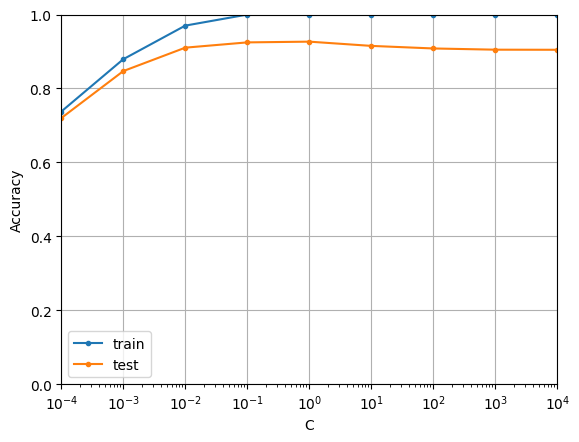

In [32]:
# Implement. Do not change the name or signature of this function.
def plot_curve_embedded(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of regularization.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with C on the x-axis and accuracy on
    the y-axis.
    """
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=0)

    # Define the range of C values
    C_values = np.logspace(-4, 4, num=9)

    # Plot the curve
    plot_live(X_train, y_train, evaluate_LR, "C", C_values, scale='log', ylim=(0, 1), ylabel='Accuracy')
    
plot_curve_embedded(X_embedded,y,0.25)

In [33]:
validation.signature_unchanged(plot_curve_embedded)

### Question 2.2: Interpretation (1 points)
Interpret the graph. Indicate which of the following answers are correct. Run additional tests if needed.

- 'A': We can recognize Devanagari characters much better using deep learning embeddings with our linear model.
- 'B': Using the embeddings doesn't make a big difference, since the linear model is still a bottleneck.
- 'C': The dimensionality of the deep learning embedding is much higher, with more than twice the number of features compared to the original pixel representation.
- 'D': The dimensionality of the deep learning embedding is much lower, with less than half the number of featuress compared to the original pixel representation.
- 'E': The dimensionality of the deep learning embedding is comparable to the original pixel representation (less than 20% difference).
- 'F': The model trained on the embedded data never overfits
- 'G': Setting C=1e-4 yields a good (close to optimal) logistic regression model given this data.
- 'H': Setting C=0.1 yields a good (close to optimal) logistic regression model given this data.
- 'I': Setting C=1e4 yields a good (close to optimal) logistic regression model given this data.
- 'J': Even though the difference between the training and test score is smaller than before (when we used the pixel values), there still seems to be room for improvement if we further preprocess the data.
- 'K': The model overfits equally much, whether we use the pixel values of the embeddings.
- 'L': The optimal regularization strength (C value) is the same whether we use pixel values or embeddings to train the model.
- 'M': The optimal regularization strength (C value) is very different whether we use pixel values or embeddings to train the model.
- 'N': No answer

In [34]:
# Fill in the correct answer. Don't change the name of the variable
q_2_2 = 'A, H, J, L'

### Question 2.3: Evaluation on held-out data (1 point)
Implement the `evaluate_pixel` and `evaluate_embedding` functions that train an optimal Logistic Regression model on the given training set, and correctly evaluates it on the evaluation set. *NOTE: This is the only exercise in which you should use the evaluation set.*

Use what you learned in the previous questions to choose the right model and correctly use the given data to evaluate it.

In [35]:
def evaluate_pixel(X_train, y_train, X_eval, y_eval):
    """ Evaluate a Logistic Regression model
    X_train -- the training data
    y_train -- the training labels
    X_eval  -- the evaluation (test) data
    y_eval  -- the evaluation (test) labels
    
    Returns: the evaluation score (accuracy) of the optimal model trained on pixel data
    """
    model = LogisticRegression(C=10e-1, solver='lbfgs', random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_eval)
    return accuracy_score(y_eval, y_pred)

def evaluate_embedding(X_train, y_train, X_eval, y_eval):
    """ Evaluate a Logistic Regression model
    X_train -- the training data
    y_train -- the training labels
    X_eval  -- the evaluation (test) data
    y_eval  -- the evaluation (test) labels
    
    Returns: the evaluation score (accuracy) of the optimal model trained on pixel data
    """
    model = LogisticRegression(C=1e-1, solver='lbfgs', random_state=0)
    model.fit(X_train, y_train)
    X_eval_embedded = create_embedding(X_eval)
    y_pred = model.predict(X_eval_embedded)
    return accuracy_score(y_eval, y_pred)

# Calling the functions. Don't change these calls
pixel_lr_score = evaluate_pixel(X, y, X_eval, y_eval)
embedding_lr_score = evaluate_embedding(X_embedded, y, X_eval, y_eval)

  0%|          | 0/1438 [00:00<?, ?it/s]

In [36]:
validation.signature_unchanged(evaluate_pixel)

In [37]:
validation.signature_unchanged(evaluate_embedding)

In [38]:
print("Pixel representation score:",pixel_lr_score)
print("Embedding representation score:",embedding_lr_score)

Pixel representation score: 0.7253260869565218
Embedding representation score: 0.9536521739130435


### Question 3.1: Model inspection (2 points)

Implement a function `plot_character_coefficients` that trains 3 logistic regression models on the pixel representation (not the embeddings), one trained with C=1e-4, one with C=1e-1, and one with C=1e4. For all models, ensure convergence by setting `max_iter=1000`. Also evaluate each model by using half of the data for training and the other half for testing.

To interpret whether the model has learned something useful, we will now plot the coefficients of these three models. Remember that Logistic Regression is a binary classifier, and you can assume (see the note below) that a one-vs-rest-like approach is used for multi-class problems, hence the n-th set of coefficients in the model belong to the submodel that separates the n-th class from the rest. To plot these coefficients, you'll to reshape them into a 32x32 matrix and then plot that (e.g. using `imshow` as in previous examples).

Your function is given a character `character`. First, plot an example of this character (any will do). Then, plot the coefficients of the model that separates the character from the other characters. Repeat 3 times for the different C values. 

Hence, you should return four plots: one character plot and three coeficients plots, and they should appear next to each other (not below each other). Add the C-value and test accuracy to the title of the three coefficient plots.

Run `plot_character_coefficients` twice, once for character `ka` (or `character_01_ka`), and once for character `ga` (or `character_03_ga`).

Note: Scikit-learn actually uses [a more sophisticated approach](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py) here than simple one-vs-all. It uses the fact that Logistic Regression predicts probabilities, and hence the probabilities of each class are taken into account (in a softmax function). It will still produce one model per class.

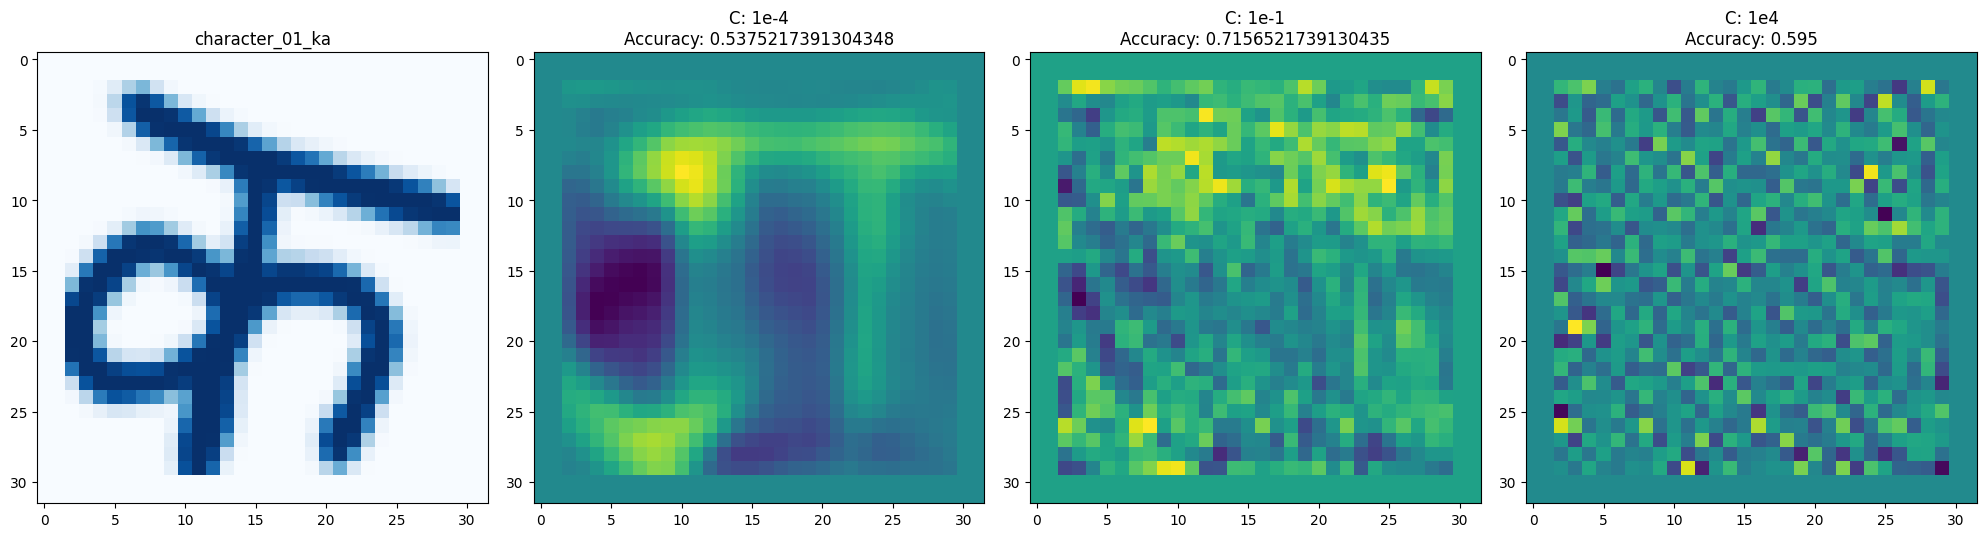

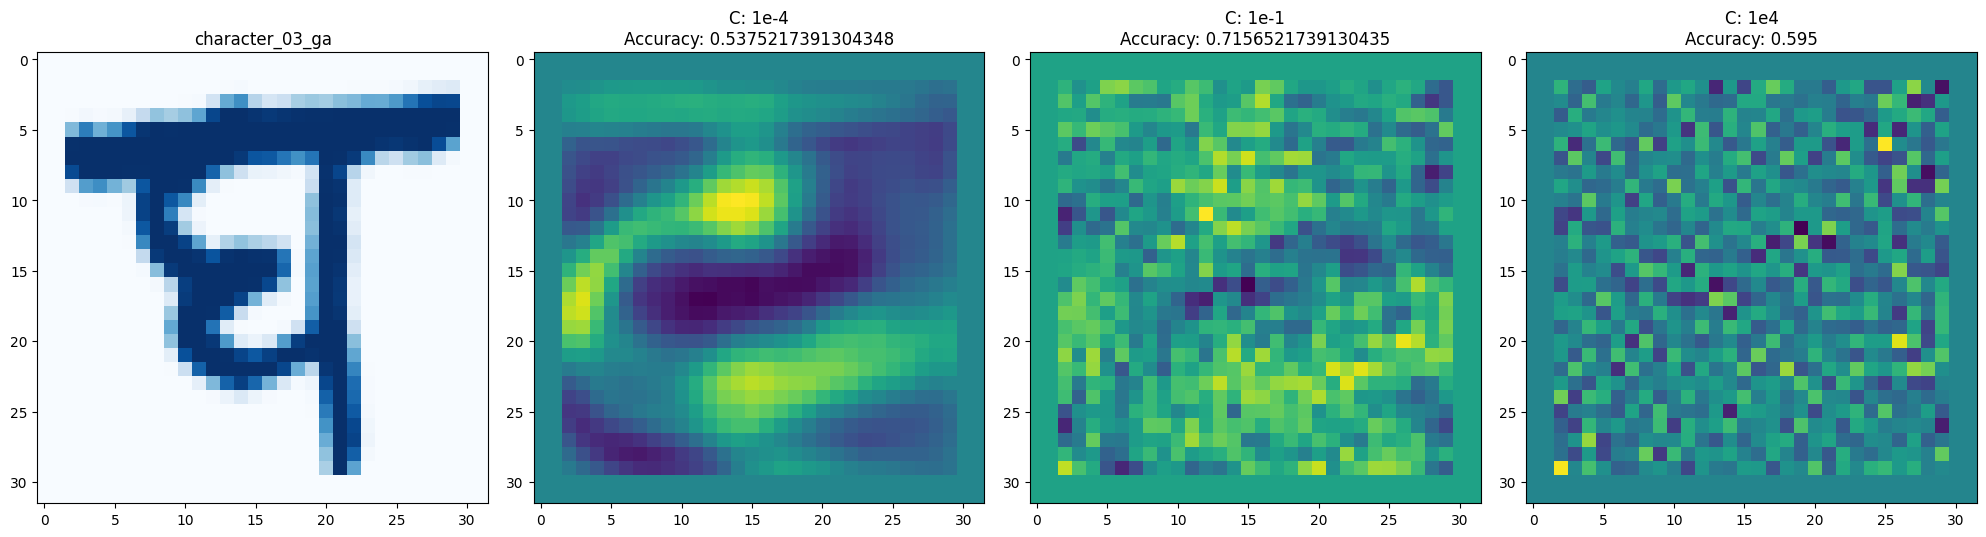

In [39]:
# Implement. Do not change the name or signature of this function.
def plot_character_coefficients(X, y, character):
    """ Plots 32x32 heatmaps showing the coefficients of three Logistic
    Regression models, each with different amounts of regularization values.
    X -- the data for training and testing
    y -- the correct labels

    Returns: 4 plots, as described above.
    """
    # Create the models
    model_1 = LogisticRegression(C=1e-4, solver='lbfgs', random_state=0, max_iter=1000)
    model_2 = LogisticRegression(C=1e-1, solver='lbfgs', random_state=0, max_iter=1000)
    model_3 = LogisticRegression(C=1e4, solver='lbfgs', random_state=0, max_iter=1000)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, stratify=y, random_state=0)

    # Fit the models
    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    model_3.fit(X_train, y_train)

    acc1 = accuracy_score(y_test, model_1.predict(X_test))
    acc2 = accuracy_score(y_test, model_2.predict(X_test))
    acc3 = accuracy_score(y_test, model_3.predict(X_test))

    # Find character index
    unique_labels = list(y.unique())
    index = unique_labels.index(character) if character in unique_labels else 0

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Create a figure with 4 subplots

    # Plot the first figure
    figure = X.iloc[index].values.reshape(32, 32)
    axs[0].imshow(figure, cmap=plt.cm.Blues)
    axs[0].set_title(character)

    # Plot the second figure
    figure = model_1.coef_[index].reshape(32, 32)
    axs[1].imshow(figure, cmap='viridis')
    axs[1].set_title(f"C: 1e-4\nAccuracy: {acc1}")

    # Plot the third figure
    figure = model_2.coef_[index].reshape(32, 32)
    axs[2].imshow(figure, cmap='viridis')
    axs[2].set_title(f"C: 1e-1\nAccuracy: {acc2}")

    # Plot the fourth figure
    figure = model_3.coef_[index].reshape(32, 32)
    axs[3].imshow(figure, cmap='viridis')
    axs[3].set_title(f"C: 1e4\nAccuracy: {acc3}")

    plt.tight_layout()  # Adjust the layout to avoid overlap
    plt.show()
    
    
plot_character_coefficients(X, y, 'character_01_ka')
plot_character_coefficients(X, y, 'character_03_ga')

In [40]:
validation.signature_unchanged(plot_character_coefficients)

### Question 3.2: Interpretation (2 points)
Interpret the graph. Indicate which of the following answers are correct.
  
- 'A': The coefficients for character `ga` and `ka` are looking very similar. Hence, the submodels for different characters are similar.
- 'B': The coefficients for character `ga` and `ka` are quite different. Hence, the submodels are all entirely unique.
- 'C': For C=1e-4, the submodels are somewhat able to capture different variations of the characters `ga` and `ka`, respectively
- 'D': For C=0.1, the submodels are somewhat able to capture different variations of the characters `ga` and `ka`, respectively
- 'E': For C=1e4, the submodels are somewhat able to capture different variations of the characters `ga` and `ka`, respectively
- 'F': For C=1e-4, the submodels are able to capture some common variations of the characters perfectly, but others not at all.
- 'G': For C=0.1, the submodels are able to capture some common variations of the characters perfectly, but others not at all.
- 'H': For C=1e4, the submodels are able to capture some common variations of the characters perfectly, but others not at all.
- 'I': If the model capture some common variations of the characters perfectly, but others not at all, it is overfitting.
- 'J': If the model capture some common variations of the characters perfectly, but others not at all, it is underfitting.
- 'K': All parameters of the model are used effectively.
- 'L': The data has certain artifacts meaning that many parameters of the model aren't used at all.
- 'M': No answer

In [41]:
# Fill in the correct answer(s). Don't change the name of the variable
q_3_2 = 'B, D, F, J, L'

### Question 3.3: Confusion matrix heatmap (1 point)

**From now on, we'll only use the embedded data**. Plot the confusion matrix for all the 46 characters classes as a heatmap. First split the data again in a default stratified train-test split using C=1e-1. Train a Logistic Regression model on the training data and produce the predictions on the test set. Compute the confusion matrix based on the predictions on the testing data. Plot the matrix as a heatmap, making sure that you at least show the correct labels (characters) on the X and Y axis. Given the large number of classes, there is no need to display in the plot the number (or percentages) corresponding to each cell of the matrix.

Implement `plot_confusion_matrix()` function to compute the confusion matrix (using [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)) and to display the matrix as a heatmap.

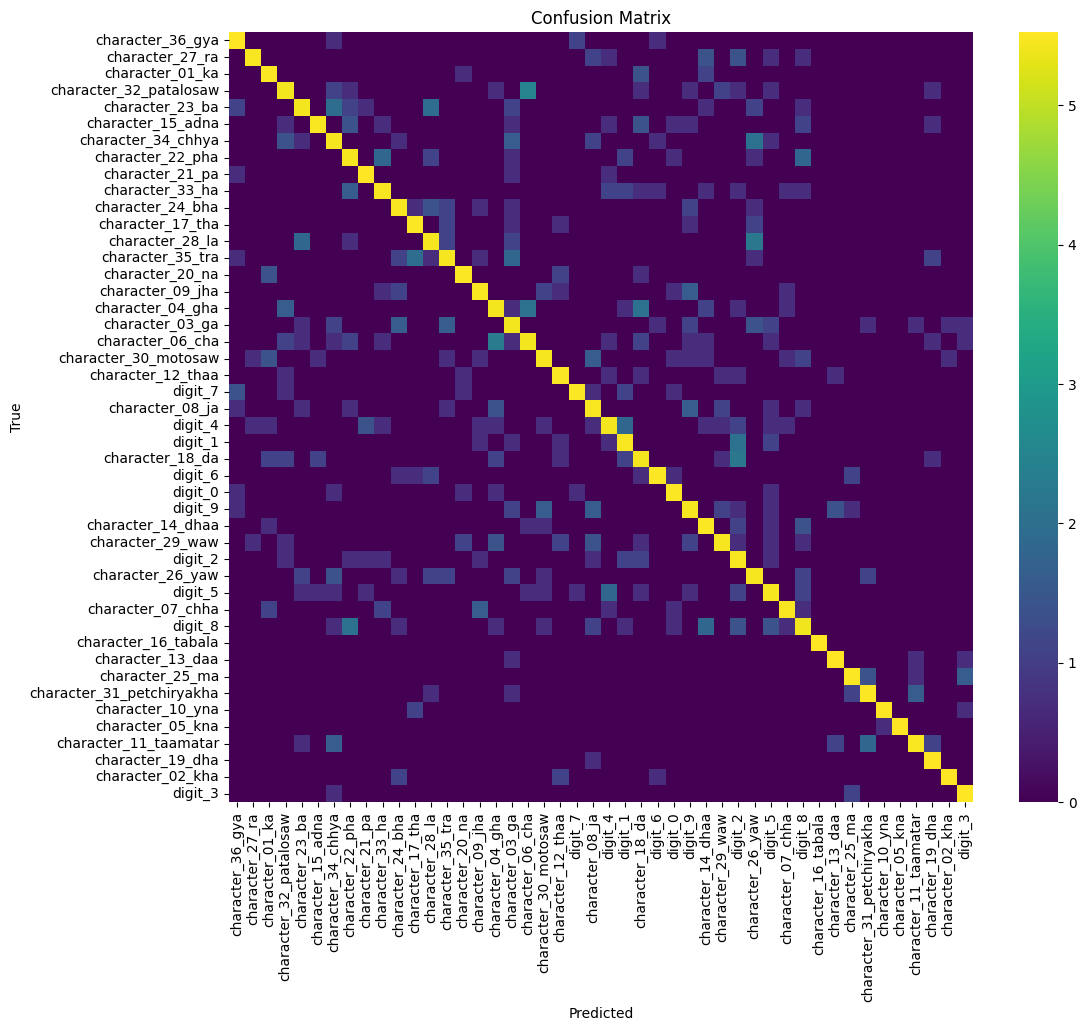

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Implement the confusion matrix plot here

def plot_confusion_matrix(X, y):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    # Train a Logistic Regression model
    model = LogisticRegression(C=1e-1, solver='lbfgs', random_state=0)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    log_conf_matrix = np.log1p(cm)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(log_conf_matrix, annot=False, cmap='viridis', fmt='d', xticklabels=y.unique(), yticklabels=y.unique())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

  

plot_confusion_matrix(X_embedded, y)

In [43]:
validation.signature_unchanged(plot_confusion_matrix)

### Question 3.4: Interpretation (1 point)
Interpret the missclassifications of the Logistic Regression model. Indicate which of the following answers are correct.
  
- 'A': Letters are sometimes confused with other letters, and numbers are sometimes confused with other numbers, but numbers are never confused by letters.
- 'B': Letters and numbers are sometimes confused, but quite rarely.
- 'C': Letters and numbers are confused very often.
- 'D': The model often confuses the character `dha` with `gha`
- 'E': The model often confuses the character `ka` with `gha`
- 'F': The model often mistakes the character `bha` for a `ma` but seldomly a `ma` for a `bha`
- 'G': The letters that are most often confused with each other usually look very similar indeed.
- 'H': The model makes lots of mistakes, even for letters which are very different.
- 'I': No answer

In [44]:
# Fill in the correct answer. Don't change the name of the variable
q_3_4 = 'B'

## Question 4 (2 points)

On a vacation in India you wonder though a dense forest. You get lost and by accident you discover a hidden temple. Over the entrance is a small text, which you recognize as Devanagari. Luckily you have recently done an assignment on this and you can load your model on your phone (because why not). You take a picture and with some quick cropping you get 32x32 images, one for each character. 

The code below imports them into the notebook. Use your best model to predict what the text means. Of course you only get the character names, you may need to do a quick search to find what it means in English. What have you just discovered?

Use your best model with embeddings to classify these images. Implement a small method `predict_characters` that returns the right character names (e.g. [`ka`,`ga`]).

In [45]:
import urllib.request
url = 'https://drive.google.com/uc?export=download&id=1uPcfQJrCBZcWyVQ_v1jv6ylzqEF_1ceg'
output = 'mystery_indian_characters.npy'
urllib.request.urlretrieve(url, filename=output)
temple_data = np.load('mystery_indian_characters.npy')

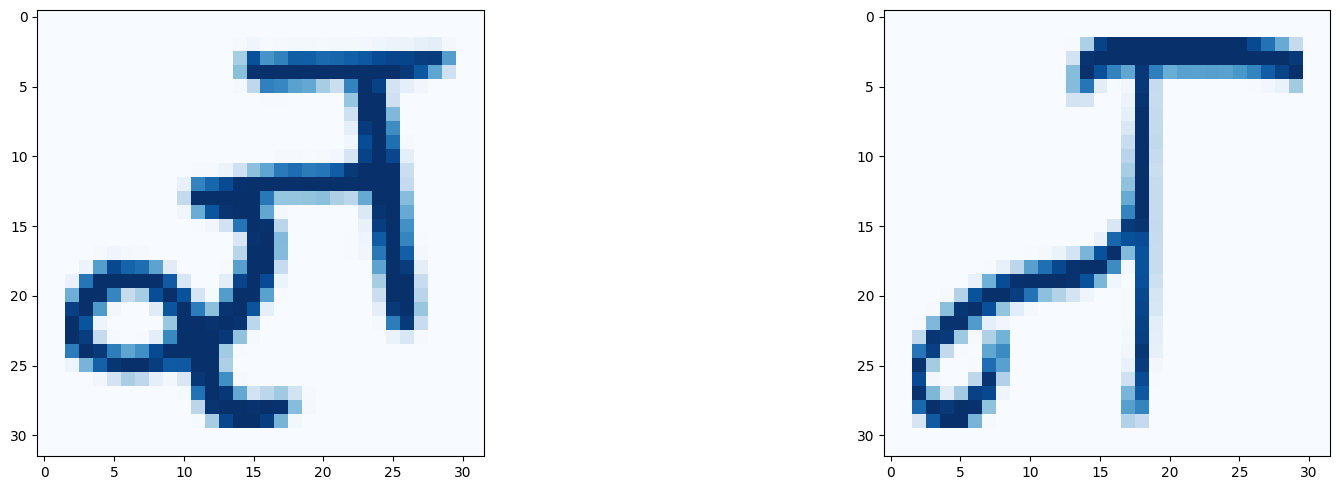

In [46]:
# Plot the images in the temple_data

fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # Create a figure with 2 subplots

# Plot the first figure
figure = temple_data[0].reshape(32, 32)
axs[0].imshow(figure, cmap=plt.cm.Blues)

# Plot the second figure
figure = temple_data[1].reshape(32, 32)
axs[1].imshow(figure, cmap=plt.cm.Blues)

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()



In [47]:
# Implement. Do not change the name or signature of this function.
def predict_characters(X, y, X_test):
    """ Print the class names for all the images in X.
    X -- the data for training and testing
    y -- the correct labels
    X_test -- the new input images as 1D arrays
    
    Returns: an array with the classified characters
    """
    # Split the data into train and test sets
    # X_train, X_tests, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    # Train a Logistic Regression model
    model = LogisticRegression(C=1e-1, solver='lbfgs', random_state=0, max_iter=1000)
    # model.fit(X_train, y_train)
    model.fit(X, y)
    # print(accuracy_score(y_test, model.predict(X_tests)))

    # Embed the test data
    X_test_embedded = create_embedding(X_test)
    # Predict on the test set
    y_pred = model.predict(X_test_embedded)

    return [y_pred[i].split('_')[-1] for i in range(len(y_pred))]

characters = predict_characters(X_embedded, y, temple_data)

print("You have discovered:", *characters)

  0%|          | 0/1 [00:00<?, ?it/s]

You have discovered: gya na


In [48]:
# Translate characters to Devanagari
devanagari_characters = [Devanagari_mapping[char] for char in characters]
print("In Devanagari:", *devanagari_characters)

In Devanagari: ज्ञ न


Copying devanagari_characters and pasting them in google translate we get:

**Hindi <---> English**

ज्ञान <---> knowledge